# Inference Results and Analysis

### Imports and Defs

In [1]:
import sys
sys.path.append("..")

In [2]:
import resource
from functools import partial

In [3]:
import torch
import py3Dmol
import numpy as np
import lightning as L
import matplotlib.pyplot as plt
from pathlib import Path
from rdkit import RDLogger, Chem
from openbabel import pybel
from torchmetrics import MetricCollection
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

In [4]:
import fegnn.util.rdkit as smolRD
import fegnn.util.functional as smolF
import fegnn.util.metrics as Metrics
from fegnn.models.fm import MolecularCFM, Integrator
from fegnn.util.tokeniser import Vocabulary
from fegnn.models.egnn import EquiInvDynamics, SemlaGenerator
from fegnn.data.datasets import GeometricDataset
from fegnn.data.datamodules import GeometricInterpolantDM
from fegnn.data.interpolate import GeometricInterpolant, GeometricNoiseSampler

In [5]:
QM9_COORDS_STD_DEV = 1.7223433256149292
GEOM_COORDS_STD_DEV = 2.407038688659668

QM9_BUCKET_LIMITS = [12, 16, 18, 20, 22, 24, 30]
GEOM_BUCKET_LIMITS = [24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 72, 96, 192]

COORD_NOISE_SCALE = 0.20

In [6]:
CKPT_PATH = "../../../models/geom-final/last.ckpt"
DATA_PATH = "../../../data/geom-drugs/smol"
DATASET = "geom-drugs"
BATCH_SIZE = 7200
N_VALIDATION_MOLS = 1000
BUCKET_COST_SCALE = "linear"

### Some Helper Functions

In [7]:
def disable_mol_stdout():
    pybel.ob.obErrorLog.StopLogging()
    RDLogger.DisableLog('rdApp.*')

In [8]:
def configure_fs(limit=4096):
    """
    Try to increase the limit on open file descriptors
    If not possible use a different strategy for sharing files in torch
    """

    n_file_resource = resource.RLIMIT_NOFILE
    soft_limit, hard_limit = resource.getrlimit(n_file_resource)

    print(f"Current limits (soft, hard): {(soft_limit, hard_limit)}")

    if limit > soft_limit:
        try:
            print(f"Attempting to increase open file limit to {limit}...")
            resource.setrlimit(n_file_resource, (limit, hard_limit))
            print("Limit changed successfully!")

        except:
            print("Limit change unsuccessful. Using torch file_system file sharing strategy instead.")

            import torch.multiprocessing
            torch.multiprocessing.set_sharing_strategy("file_system")

    else:
        print("Open file limit already sufficiently large.")


In [9]:
def build_vocab():
    # Need to make sure PAD has index 0
    special_tokens = ["<PAD>", "<MASK>"]
    core_atoms = ["H", "C", "N", "O", "F", "P", "S", "Cl"]
    other_atoms = ["Br", "B", "Al", "Si", "As", "I", "Hg", "Bi"]
    tokens = special_tokens + core_atoms + other_atoms
    return Vocabulary(tokens)

In [10]:
def mol_transform(molecule, vocab, n_bonds, coord_std):
    rotation = tuple(np.random.rand(3) * np.pi * 2)
    molecule = molecule.scale(1.0 / coord_std).rotate(rotation).zero_com()

    atomic_nums = [int(atomic) for atomic in molecule.atomics.tolist()]
    tokens = [smolRD.PT.symbol_from_atomic(atomic) for atomic in atomic_nums]
    one_hots = torch.tensor(vocab.indices_from_tokens(tokens, one_hot=True))

    bond_types = smolF.one_hot_encode_tensor(molecule.bond_types, n_bonds)

    charges = [smolRD.CHARGE_IDX_MAP[charge] for charge in molecule.charges.tolist()]
    charges = torch.tensor(charges)

    transformed = molecule._copy_with(atomics=one_hots, bond_types=bond_types, charges=charges)
    return transformed

In [11]:
def build_dm(data_path, dataset, hparams, vocab):
    if dataset == "qm9":
        coord_std = QM9_COORDS_STD_DEV
        bucket_limits = QM9_BUCKET_LIMITS

    elif dataset == "geom-drugs":
        coord_std = GEOM_COORDS_STD_DEV
        bucket_limits = GEOM_BUCKET_LIMITS

    else:
        raise ValueError(f"Unknown dataset {dataset}")
 
    data_path = Path(data_path)

    n_bond_types = 5
    transform = partial(mol_transform, vocab=vocab, n_bonds=n_bond_types, coord_std=coord_std)

    val_dataset = GeometricDataset.load(data_path / "val.smol", transform=transform)
    val_dataset = val_dataset.sample(N_VALIDATION_MOLS)

    type_mask_index = vocab.indices_from_tokens(["<MASK>"])[0] if hparams["val-type-interpolation"] == "mask" else None
    bond_mask_index = None

    prior_sampler = GeometricNoiseSampler(
        vocab.size,
        n_bond_types,
        coord_noise="gaussian",
        type_noise=hparams["val-prior-type-noise"],
        bond_noise=hparams["val-prior-bond-noise"],
        scale_log_size=True,
        scale_factor=COORD_NOISE_SCALE,
        zero_com=True,
        type_mask_index=type_mask_index,
        bond_mask_index=bond_mask_index
    )
    eval_interpolant = GeometricInterpolant(
        prior_sampler,
        coord_interpolation="linear",
        type_interpolation=hparams["val-type-interpolation"],
        bond_interpolation=hparams["val-bond-interpolation"],
        equivariant_ot=False,
        batch_ot=False,
        fixed_time=0.9
    )
    dm = GeometricInterpolantDM(
        None,
        val_dataset,
        None,
        hparams["batch-cost"],
        val_interpolant=eval_interpolant,
        test_interpolant=eval_interpolant,
        bucket_limits=bucket_limits,
        bucket_cost_scale=BUCKET_COST_SCALE,
        pad_to_bucket=False
    )
    return dm

In [12]:
def load_model(ckpt_path, vocab, integration_steps=None, train_smiles=None):
    checkpoint = torch.load(ckpt_path)
    hparams = checkpoint["hyper_parameters"]

    steps = integration_steps if integration_steps is not None else hparams["integration-steps"]
    hparams["integration-steps"] = steps

    d_model = hparams["d_model"]
    dynamics = EquiInvDynamics(
        d_model,
        hparams["d_message"],
        hparams["n_coord_sets"],
        hparams["n_layers"],
        n_neighbours_feats=hparams["n_neighbours_feats"],
        d_message_hidden=hparams["d_message_hidden"],
        d_edge=hparams["d_edge"],
        self_cond=hparams["self_cond"],
        coord_norm=hparams["coord_norm"],
    )
    egnn_gen = SemlaGenerator(
        d_model,
        dynamics,
        vocab.size,
        hparams["n_atom_feats"],
        d_edge=hparams["d_edge"],
        n_edge_types=5,
        self_cond=hparams["self_cond"],
        size_emb=hparams["size_emb"],
        max_atoms=hparams["max_atoms"]
    )

    type_mask_index = vocab.indices_from_tokens(["<MASK>"])[0] if hparams["train-type-interpolation"] == "mask" else None
    bond_mask_index = None

    integrator = Integrator(
        steps,
        type_strategy=hparams["integration-type-strategy"],
        bond_strategy=hparams["integration-bond-strategy"],
        type_mask_index=type_mask_index,
        bond_mask_index=bond_mask_index,
        cat_noise_level=hparams["integration-cat-noise-level"]
    )

    hparams["compile_model"] = False
    fm_model = MolecularCFM.load_from_checkpoint(
        ckpt_path,
        gen=egnn_gen,
        vocab=vocab,
        integrator=integrator,
        train_smiles=train_smiles,
        type_mask_index=type_mask_index,
        bond_mask_index=bond_mask_index,
        **hparams
    )
    return fm_model

In [13]:
def display_mol(mol, style="stick", surface=False, size=(300, 300)):
    assert style in ["line", "stick", "sphere"]

    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(Chem.MolToMolBlock(mol), "mol")

    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS)

    viewer.zoomTo()
    viewer.show()

### Setup Objects and Data

In [14]:
disable_mol_stdout()
configure_fs()

Current limits (soft, hard): (4096, 4096)
Open file limit already sufficiently large.


In [15]:
# Load the train data separately from the DM, just to access the list of train SMILES
train_path = Path(DATA_PATH) / "train.smol"
train_dataset = GeometricDataset.load(train_path)
train_smiles = [mol.str_id for mol in train_dataset]

In [15]:
vocab = build_vocab()

In [16]:
# model = load_model(CKPT_PATH, vocab, train_smiles=train_smiles)
model = load_model(CKPT_PATH, vocab)
model.pairwise_metrics = False

In [17]:
print(f"coord-scale {model.coord_scale}")
for key, val in model.integrator.hparams.items():
    print(f"{key} {val}")

coord-scale 2.407038688659668
integration-steps 100
integration-coord-noise-std 0.0
integration-type-strategy uniform-sample
integration-bond-strategy uniform-sample
integration-cat-noise-level 1


In [18]:
checkpoint = torch.load(CKPT_PATH)
hparams = checkpoint["hyper_parameters"]
dm = build_dm(DATA_PATH, DATASET, hparams, vocab)
checkpoint = None

In [19]:
trainer = L.Trainer()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/khdv294/mambaforge/envs/equinv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


### Check Validation Works

In [31]:
metrics = trainer.validate(model, datamodule=dm)[0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [24, 42, 68, 102, 138, 143, 163, 108, 79, 54, 39, 26, 11, 3]
bucket batch sizes [168, 144, 128, 112, 104, 96, 88, 80, 72, 72, 64, 56, 40, 24]
batches per bucket [1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9976658225059509
       val-energy            155.7473602294922
   val-energy-per-atom      3.5166285037994385
   val-energy-validity       0.921999990940094
     val-fc-validity        0.9010000228881836
 val-molecule-stability      0.972000002861023
 val-opt-energy-validity     0.921999990940094
      val-opt-rmsd          1.0220849514007568
       val-strain           115.42186737060547
   val-strain-per-atom      2.6125471591949463
     val-uniqueness                 1.0
      val-validity          0.9240000247955322
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [32]:
print(metrics)

{'val-atom-stability': 0.9976658225059509, 'val-molecule-stability': 0.972000002861023, 'val-energy': 155.7473602294922, 'val-energy-per-atom': 3.5166285037994385, 'val-energy-validity': 0.921999990940094, 'val-fc-validity': 0.9010000228881836, 'val-opt-energy-validity': 0.921999990940094, 'val-opt-rmsd': 1.0220849514007568, 'val-strain': 115.42186737060547, 'val-strain-per-atom': 2.6125471591949463, 'val-uniqueness': 1.0, 'val-validity': 0.9240000247955322}


### Integration Strategies

In [33]:
model.sampling_strategy = "log"
metrics = trainer.validate(model, datamodule=dm)[0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [24, 42, 68, 102, 138, 143, 163, 108, 79, 54, 39, 26, 11, 3]
bucket batch sizes [168, 144, 128, 112, 104, 96, 88, 80, 72, 72, 64, 56, 40, 24]
batches per bucket [1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9984962344169617
       val-energy           153.73416137695312
   val-energy-per-atom       3.40887451171875
   val-energy-validity      0.9350000023841858
     val-fc-validity        0.9039999842643738
 val-molecule-stability     0.9779999852180481
 val-opt-energy-validity    0.9350000023841858
      val-opt-rmsd          1.0691604614257812
       val-strain             112.34521484375
   val-strain-per-atom      2.4746592044830322
     val-uniqueness                 1.0
      val-validity          0.9359999895095825
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [34]:
model.sampling_strategy = "log"
model.integrator.steps = 50
metrics = trainer.validate(model, datamodule=dm)[0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [24, 42, 68, 102, 138, 143, 163, 108, 79, 54, 39, 26, 11, 3]
bucket batch sizes [168, 144, 128, 112, 104, 96, 88, 80, 72, 72, 64, 56, 40, 24]
batches per bucket [1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9985635876655579
       val-energy            175.4678192138672
   val-energy-per-atom       3.935638427734375
   val-energy-validity      0.9359999895095825
     val-fc-validity        0.8920000195503235
 val-molecule-stability     0.9700000286102295
 val-opt-energy-validity    0.9359999895095825
      val-opt-rmsd          1.1147125959396362
       val-strain            134.466064453125
   val-strain-per-atom      3.0326154232025146
     val-uniqueness                 1.0
      val-validity          0.9380000233650208
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Integration Steps

Check results for different numbers of integration steps

In [26]:
inf_metrics = []
model_steps = [5, 10, 20, 50, 100, 200]

for steps in model_steps:
    model.integrator.steps = steps
    metrics = trainer.validate(model, datamodule=dm)[0]
    inf_metrics.append(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [39, 74, 132, 225, 290, 295, 264, 229, 194, 113, 77, 43, 20, 5]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.6618413925170898
       val-energy            1908.772216796875
     val-fc-validity       0.0005000000237487257
 val-molecule-stability             0.0
     val-uniqueness                 1.0
      val-validity          0.06400000303983688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [39, 74, 132, 225, 290, 295, 264, 229, 194, 113, 77, 43, 20, 5]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.8653666973114014
       val-energy            796.0638427734375
     val-fc-validity        0.06949999928474426
 val-molecule-stability     0.06599999964237213
     val-uniqueness                 1.0
      val-validity          0.15399999916553497
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [39, 74, 132, 225, 290, 295, 264, 229, 194, 113, 77, 43, 20, 5]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9609230160713196
       val-energy            402.6440124511719
     val-fc-validity        0.48750001192092896
 val-molecule-stability     0.5065000057220459
     val-uniqueness                 1.0
      val-validity           0.550000011920929
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [39, 74, 132, 225, 290, 295, 264, 229, 194, 113, 77, 43, 20, 5]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9891571402549744
       val-energy           282.60601806640625
     val-fc-validity        0.8050000071525574
 val-molecule-stability      0.871999979019165
     val-uniqueness                 1.0
      val-validity          0.8309999704360962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [39, 74, 132, 225, 290, 295, 264, 229, 194, 113, 77, 43, 20, 5]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9918482303619385
       val-energy            258.0427551269531
     val-fc-validity        0.8450000286102295
 val-molecule-stability     0.9164999723434448
     val-uniqueness                 1.0
      val-validity          0.8744999766349792
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [39, 74, 132, 225, 290, 295, 264, 229, 194, 113, 77, 43, 20, 5]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability        0.994920551776886
       val-energy            250.6403350830078
     val-fc-validity        0.8615000247955322
 val-molecule-stability     0.9304999709129333
     val-uniqueness                 1.0
      val-validity          0.8870000243186951
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [27]:
val_atom_stabilities = [metrics["val-atom-stability"] for metrics in inf_metrics]
val_mol_stabilities = [metrics["val-molecule-stability"] for metrics in inf_metrics]
val_validities = [metrics["val-validity"] for metrics in inf_metrics]
val_fc_validities = [metrics["val-fc-validity"] for metrics in inf_metrics]

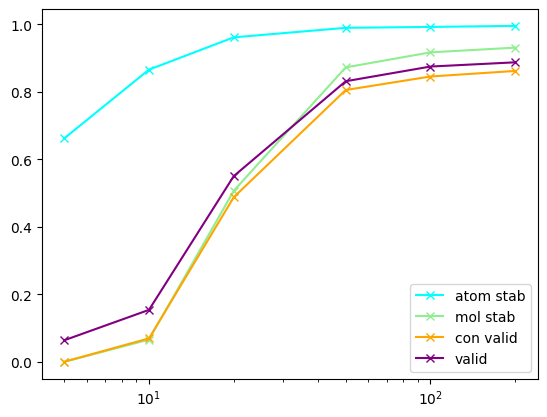

In [28]:
plt.plot(model_steps, val_atom_stabilities, marker="x", color="aqua", label="atom stab")
plt.plot(model_steps, val_mol_stabilities, marker="x", color="lightgreen", label="mol stab")
plt.plot(model_steps, val_fc_validities, marker="x", color="orange", label="con valid")
plt.plot(model_steps, val_validities, marker="x", color="purple", label="valid")

plt.xscale("log")
plt.legend()
plt.show()

### Try adding noise to the inference

Fix the number of integration steps and try different values of noise to see what happens to the generated molecules

In [22]:
INTEGRATION_STEPS = 50

In [23]:
noises = [0.1, 0.2, 0.5]
integrators = []

for noise in noises:
    integrator = Integrator(
        INTEGRATION_STEPS,
        coord_noise_std=noise,
        type_strategy=model.integrator.type_strategy,
        bond_strategy=model.integrator.bond_strategy,
        type_mask_index=model.integrator.type_mask_index,
        bond_mask_index=model.integrator.bond_mask_index,
        cat_noise_level=model.integrator.cat_noise_level
    )
    integrators.append(integrator)

In [24]:
inf_metrics = []
for integrator in integrators:
    model.integrator = integrator
    metrics = trainer.validate(model, datamodule=dm)[0]
    inf_metrics.append(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [45, 77, 158, 199, 289, 300, 280, 240, 153, 112, 83, 46, 17, 1]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 3, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9958785176277161
       val-energy           301.11016845703125
     val-fc-validity        0.8134999871253967
 val-molecule-stability     0.8709999918937683
       val-novelty          0.9982196092605591
     val-uniqueness                 1.0
      val-validity          0.8424999713897705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [45, 77, 158, 199, 289, 300, 280, 240, 153, 112, 83, 46, 17, 1]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 3, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9958785176277161
       val-energy           294.61639404296875
     val-fc-validity         0.809499979019165
 val-molecule-stability     0.8784999847412109
       val-novelty          0.9970059990882874
     val-uniqueness                 1.0
      val-validity          0.8349999785423279
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [45, 77, 158, 199, 289, 300, 280, 240, 153, 112, 83, 46, 17, 1]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 3, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9959351420402527
       val-energy           301.76934814453125
     val-fc-validity        0.8034999966621399
 val-molecule-stability     0.8790000081062317
       val-novelty          0.9981992840766907
     val-uniqueness                 1.0
      val-validity          0.8330000042915344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Different amounts of categorical noise

In [25]:
INTEGRATION_STEPS = 100

In [26]:
noise_levels = [1, 2, 3, 5, 10]

inf_metrics = []
for level in noise_levels:
    integrator = Integrator(
        INTEGRATION_STEPS,
        type_strategy="uniform-sample",
        bond_strategy="uniform-sample",
        cat_noise_level=level
    )
    model.integrator = integrator
    metrics = trainer.validate(model, datamodule=dm)[0]
    inf_metrics.append(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [45, 77, 158, 199, 289, 300, 280, 240, 153, 112, 83, 46, 17, 1]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 3, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9974523782730103
       val-energy            280.2646179199219
     val-fc-validity        0.8615000247955322
 val-molecule-stability      0.921500027179718
       val-novelty          0.9977490305900574
     val-uniqueness                 1.0
      val-validity          0.8884999752044678
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [45, 77, 158, 199, 289, 300, 280, 240, 153, 112, 83, 46, 17, 1]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 3, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9964107275009155
       val-energy            271.7619323730469
     val-fc-validity        0.8450000286102295
 val-molecule-stability     0.9075000286102295
       val-novelty          0.9959561228752136
     val-uniqueness                 1.0
      val-validity          0.8654999732971191
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [45, 77, 158, 199, 289, 300, 280, 240, 153, 112, 83, 46, 17, 1]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 3, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9943839311599731
       val-energy           285.63494873046875
     val-fc-validity        0.8040000200271606
 val-molecule-stability     0.8510000109672546
       val-novelty          0.9975947141647339
     val-uniqueness                 1.0
      val-validity          0.8314999938011169
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [45, 77, 158, 199, 289, 300, 280, 240, 153, 112, 83, 46, 17, 1]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 3, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.9803211092948914
       val-energy            326.2793884277344
     val-fc-validity        0.6380000114440918
 val-molecule-stability     0.6585000157356262
       val-novelty          0.9992636442184448
     val-uniqueness                 1.0
      val-validity          0.6790000200271606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



items per bucket [45, 77, 158, 199, 289, 300, 280, 240, 153, 112, 83, 46, 17, 1]
bucket batch sizes [266, 228, 200, 177, 160, 145, 133, 123, 114, 106, 100, 88, 66, 33]
batches per bucket [1, 1, 1, 2, 2, 3, 3, 2, 2, 2, 1, 1, 1, 1]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   val-atom-stability       0.8373944163322449
       val-energy            530.7355346679688
     val-fc-validity        0.15700000524520874
 val-molecule-stability     0.15449999272823334
       val-novelty                  1.0
     val-uniqueness                 1.0
      val-validity           0.226500004529953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Analyse Model Outputs

In [20]:
def mol_from_tensors(vocab, coords, atom_dists, bond_dists=None, charge_dists=None):
    # Take index with highest probability and convert to token
    vocab_indices = torch.argmax(atom_dists, dim=1).tolist()
    tokens = vocab.tokens_from_indices(vocab_indices)

    # Convert to atomic number bond list format
    bonds = None
    if bond_dists is not None:
        bond_types = torch.argmax(bond_dists, dim=-1)
        bonds = smolF.bonds_from_adj(bond_types)
        bonds = bonds.long().numpy()

    # Convert index from model to actual atom charge
    charges = None
    if charge_dists is not None:
        charge_types = torch.argmax(charge_dists, dim=-1).tolist()
        charges = [smolRD.IDX_CHARGE_MAP[idx] for idx in charge_types]
        charges = np.array(charges)

    coords = coords.numpy()
    return smolRD.mol_from_atoms(coords, tokens, bonds=bonds, charges=charges, sanitize=False)


def mols_from_tensors(vocab, coords, atom_dists, mask, bond_dists=None, charge_dists=None):
    coords_list = []
    atom_dists_list = []
    bond_dists_list = []
    charge_dists_list = []

    n_atoms = mask.sum(dim=1)
    for idx in range(coords.size(0)):
        mol_atoms = n_atoms[idx]
        mol_coords = coords[idx, :mol_atoms, :].cpu()
        mol_token_dists = atom_dists[idx, :mol_atoms, :].cpu()

        coords_list.append(mol_coords)
        atom_dists_list.append(mol_token_dists)

        if bond_dists is not None:
            mol_bond_dists = bond_dists[idx, :mol_atoms, :mol_atoms, :].cpu()
            bond_dists_list.append(mol_bond_dists)
        else:
            bond_dists_list.append(None)

        if charge_dists is not None:
            mol_charge_dists = charge_dists[idx, :mol_atoms, :].cpu()
            charge_dists_list.append(mol_charge_dists)
        else:
            charge_dists_list.append(None)

    zipped = zip(coords_list, atom_dists_list, bond_dists_list, charge_dists_list)
    mols = [mol_from_tensors(vocab, *ts) for ts in zipped]
    return mols


def generate_mols(generated, vocab, use_bonds=True):
    coords = generated["coords"]
    atom_dists = generated["atomics"]
    bond_dists = generated["bonds"] if use_bonds else None
    charge_dists = generated["charges"] if use_bonds else None
    masks = generated["mask"]

    mols = mols_from_tensors(
        vocab,
        coords,
        atom_dists,
        masks,
        bond_dists=bond_dists,
        charge_dists=charge_dists
    )
    return mols

In [21]:
def check_invalidities(mols):
    problems = {
        "atom-valence": 0,
        "atom-kekulize": 0,
        "kekulize": 0
    }
    mol_idxs = {key: [] for key in problems.keys()}

    for idx, mol in enumerate(mols):
        if mol is None:
            continue
        try:
            Chem.SanitizeMol(Chem.Mol(mol))
        except Chem.AtomValenceException:
            problems["atom-valence"] += 1
            mol_idxs["atom-valence"].append(idx)
        except Chem.AtomKekulizeException:
            problems["atom-kekulize"] += 1
            mol_idxs["atom-kekulize"].append(idx)
        except Chem.KekulizeException:
            problems["kekulize"] += 1
            mol_idxs["kekulize"].append(idx)

    return problems, mol_idxs

In [22]:
CKPT_PATH = "../../../models/geom-final/last.ckpt"
INTEGRATION_STEPS = 100
CAT_NOISE_LEVEL = 1

In [23]:
integrator = Integrator(
    INTEGRATION_STEPS,
    type_strategy=model.integrator.type_strategy,
    bond_strategy=model.integrator.bond_strategy,
    type_mask_index=model.integrator.type_mask_index,
    bond_mask_index=model.integrator.bond_mask_index,
    cat_noise_level=CAT_NOISE_LEVEL
)

In [24]:
# Choose a value for integration steps and analyse the output molecules
# model = load_model(CKPT_PATH, vocab, integration_steps=INTEGRATION_STEPS, train_smiles=train_smiles)
model.integrator = integrator

In [25]:
val_dl = dm.val_dataloader()
val_iter = iter(val_dl)
batch = next(val_iter)[0]


items per bucket [25, 30, 74, 123, 122, 148, 156, 113, 92, 58, 36, 17, 5, 1]
bucket batch sizes [168, 144, 128, 112, 104, 96, 88, 80, 72, 72, 64, 56, 40, 24]
batches per bucket [1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]


In [26]:
model = model.to("cuda")
batch = {k: v.cuda() for k, v in batch.items()}
output = model._generate(batch, INTEGRATION_STEPS)

In [27]:
mols = model._generate_mols(output)
smiles = [smolRD.smiles_from_mol(mol) if mol is not None else None for mol in mols]

In [28]:
for idx, smi in enumerate(smiles):
    print(f"{idx:<6}{smi}")

0     [H]c1c([H])c([H])c(N([H])N([H])C(=O)C(=O)N([H])c2c([H])c([H])c([H])c([H])c2OC([H])([H])[H])c(Cl)c1[H]
1     [H]OC(=O)C([H])(N1C(=O)C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
2     [H]OC([H])([H])C([H])(O[H])c1c([H])c(OC([H])([H])[H])c2c(c1OC(=O)N([H])[H])OC([H])([H])C([H])([H])O2
3     [H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1N([H])C(=O)C1([H])C([H])(Cl)C1(C([H])([H])[H])C([H])([H])[H]
4     [H]c1c([H])c([H])c2c(c1[H])N=C(c1c([H])c([H])c([H])c(C([H])([H])[H])c1[H])N([H])C([H])([H])C2([H])[H]
5     [H]Oc1c([H])c([H])c([H])c2c1C([H])([H])C([H])(N=C([H])c1c([H])c([H])c(Cl)c([H])c1[H])C([H])([H])C2([H])[H]
6     [H]OC(=O)C([H])(Sc1nn([H])c(=O)n1C([H])([H])[H])N([H])c1c([H])c([H])c([H])c([H])c1OC([H])([H])[H]
7     [H]c1c([H])c([H])c2c(nc(SC([H])([H])C(=O)C([H])([H])C([H])([H])C([H])([H])OC([H])([H])[H])n2[H])c1[H]
8     [H]c1c([H])c(N(C2=NC([H])([H])C([H])([H])S2)C([H])([H])C([H])([H])[H])c([N+](=O)[O-])c([H])c1C(=O)ON([H])[H]
9     [H

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

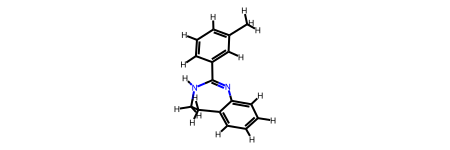

In [29]:
mols[4]

### Generate molecules directly with functions

In [27]:
gen_metrics = {
    "validity": Metrics.Validity(),
    "fc-validity": Metrics.Validity(connected=True),
    "uniqueness": Metrics.Uniqueness(),
    "energy": Metrics.AverageEnergy()
}
gen_metrics = MetricCollection(gen_metrics, compute_groups=False)

In [28]:
def forward_batches(n_batches, dm, model):
    val_dl = dm.val_dataloader()
    cuda_model = model.to("cuda")
    batch_idx = 0

    outputs = []
    for batch in val_dl:
        if batch_idx == n_batches:
            break

        batch_idx += 1
        batch = {k: v.cuda() for k, v in batch[0].items()}
        output = cuda_model._generate(batch, INTEGRATION_STEPS)
        outputs.append(output)

    return outputs

In [29]:
n_batches = 10
outputs = forward_batches(n_batches, dm, model)


items per bucket [25, 30, 74, 123, 122, 148, 156, 113, 92, 58, 36, 17, 5, 1]
bucket batch sizes [168, 144, 128, 112, 104, 96, 88, 80, 72, 72, 64, 56, 40, 24]
batches per bucket [1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]


In [45]:
mols = [generate_mols(output, vocab) for output in outputs]
mols = [mol for mol_list in mols for mol in mol_list]

In [46]:
# Compute benchmark metrics on loaded train dataset samples
gen_metrics.reset()
gen_metrics.update(mols)
results = gen_metrics.compute()

In [47]:
for metric, result in results.items():
    print(f"{metric} -- {result.item():.3f}")

energy -- 262.290
fc-validity -- 0.866
uniqueness -- 1.000
validity -- 0.886


In [48]:
problems, mol_idxs = check_invalidities(mols)

In [49]:
print(problems)

{'atom-valence': 27, 'atom-kekulize': 0, 'kekulize': 36}


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

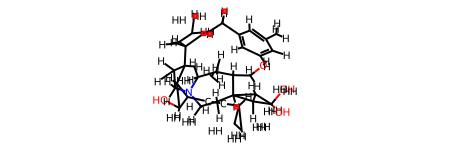

In [57]:
mol_idx = mol_idxs["atom-valence"][0]
mols[mol_idx]

## Samples Grid for Paper

In [30]:
mols = [model._generate_mols(output) for output in outputs]
mols = [mol for mol_list in mols for mol in mol_list]
valid_mols = [mol for mol in mols if mol is not None]

In [31]:
# Compute benchmark metrics on loaded train dataset samples
gen_metrics.reset()
gen_metrics.update(mols)
results = gen_metrics.compute()

for metric, result in results.items():
    print(f"{metric} -- {result.item():.3f}")

energy -- 114.258
fc-validity -- 0.911
uniqueness -- 1.000
validity -- 0.923


In [45]:
viewer = py3Dmol.view(width=800, height=800)
# sample_mols = np.random.choice(valid_mols, 9, replace=False)

In [48]:
mol_idx = 208
viewer.removeAllModels()
IPythonConsole.addMolToView(valid_mols[mol_idx], viewer)
# viewer.zoomTo()
viewer.show()
viewer.png()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [50]:
viewer.png()

In [33]:
for idx, mol in enumerate(valid_mols):
    print(f"{idx} -- {mol.GetNumAtoms()}")

0 -- 47
1 -- 45
2 -- 45
3 -- 45
4 -- 45
5 -- 47
6 -- 47
7 -- 48
8 -- 48
9 -- 46
10 -- 48
11 -- 48
12 -- 47
13 -- 45
14 -- 46
15 -- 46
16 -- 48
17 -- 47
18 -- 46
19 -- 46
20 -- 46
21 -- 46
22 -- 47
23 -- 47
24 -- 45
25 -- 47
26 -- 48
27 -- 48
28 -- 46
29 -- 46
30 -- 47
31 -- 46
32 -- 46
33 -- 45
34 -- 45
35 -- 47
36 -- 45
37 -- 47
38 -- 47
39 -- 45
40 -- 45
41 -- 46
42 -- 48
43 -- 48
44 -- 46
45 -- 45
46 -- 48
47 -- 45
48 -- 45
49 -- 47
50 -- 46
51 -- 48
52 -- 45
53 -- 48
54 -- 46
55 -- 48
56 -- 45
57 -- 48
58 -- 45
59 -- 46
60 -- 45
61 -- 48
62 -- 46
63 -- 47
64 -- 45
65 -- 46
66 -- 47
67 -- 47
68 -- 45
69 -- 48
70 -- 47
71 -- 46
72 -- 47
73 -- 46
74 -- 47
75 -- 48
76 -- 46
77 -- 46
78 -- 47
79 -- 47
80 -- 45
81 -- 47
82 -- 33
83 -- 35
84 -- 34
85 -- 35
86 -- 36
87 -- 35
88 -- 33
89 -- 36
90 -- 35
91 -- 35
92 -- 34
93 -- 33
94 -- 36
95 -- 36
96 -- 34
97 -- 33
98 -- 34
99 -- 36
100 -- 34
101 -- 36
102 -- 36
103 -- 33
104 -- 34
105 -- 36
106 -- 33
107 -- 36
108 -- 33
109 -- 36
110 -- 33
